In [1]:
# made by Gibeom LEE, HI LAB
# 한 폴더 내 모든 csv 파일의 TENG Vpp값을 구할 때 유용합니다.
# +250806 각 frequency도 같이 보여줍니다.
# +251113 Peak 감지 안되는 데이터도 그냥 보여줍니다. (Cap 차징 같은거)

In [2]:
import os
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [3]:
# ===============================
# 🛠️ 사용자 설정 영역
# ===============================

# 사용자 선택: 피크 탐지 모드
# "neg"  → 음의 피크만 (Abs. Peak Mag. 분석)
# "pos"  → 양의 피크만 (Abs. Peak Mag. 분석)
# "both" → 양/음 피크 모두 (Vpp 분석)
peak_mode = "neg"

# -------------------------------
# 폴더 경로
folder_path = r"G:\다른 컴퓨터\KHU PC\HI Lab\0. Projects\0. On going\3. Triboresistive\2. Origin\260125기범_CSV\0minimized_Fig2f"


# 사용자 설정값 (피크 필터링 기준)
prominence_ratio = 0.3  # 표준편차(std) * 비율로 prominence 기준 설정
min_prominence = 0.1 # prominence 하한 
min_distance_sec = 0.05 # 인접 피크 최소 간격(초)

# 👇 [수정] SNR 기준을 3으로 변경
snr_threshold = 3 # SNR 기준 (3으로 설정)

min_relative_height = 0.03 # 전체 최대 진폭 대비 최소 비율

# 👇 [수정] 절대값 최소 기준을 5.0V로 변경
abs_min_height = 5.0 # 절대값 몇 V는 넘어야 피크로 인정 (5.0V로 설정) 

# 그래프 Y축
y_range = (None, None)
#y_range = (-60, 60)

# csv파일 저장
save_summary_csv = False # True 로 변경하면 최종 요약 CSV 저장

⚠️ 1.First | 분석 가능한 피크가 2개 미만입니다. 분석 값: 0.0 V, 0.0 Hz
📊 1.First | 전체 분석 (0개 피크)
 - 평균 Peak value: 0.00 V
 - 표준편차: 0.00 V
 - 평균 주파수: 0.00 Hz


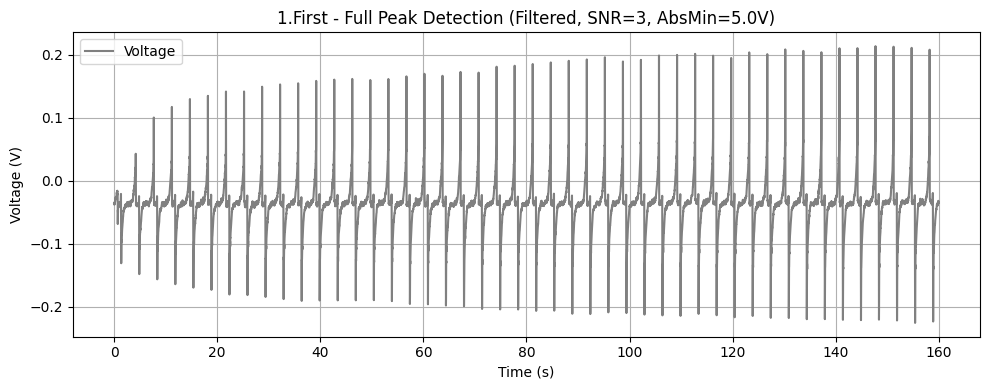

⚠️ 2.Middle | 분석 가능한 피크가 2개 미만입니다. 분석 값: 0.0 V, 0.0 Hz
📊 2.Middle | 전체 분석 (0개 피크)
 - 평균 Peak value: 0.00 V
 - 표준편차: 0.00 V
 - 평균 주파수: 0.00 Hz


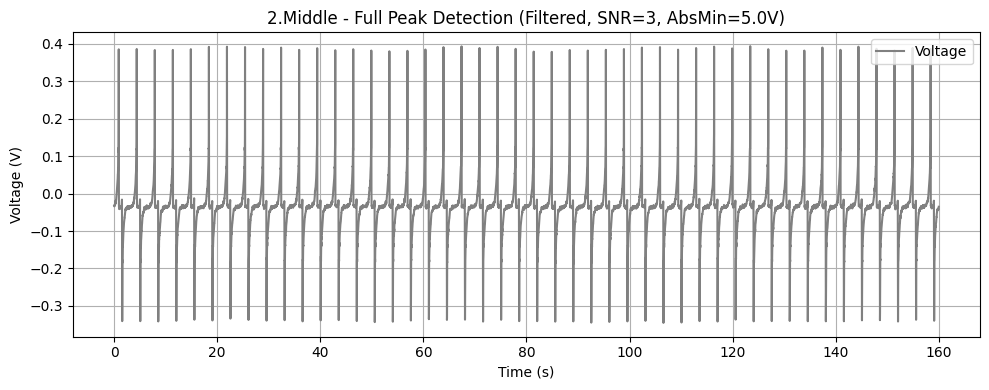

⚠️ 3.Last | 분석 가능한 피크가 2개 미만입니다. 분석 값: 0.0 V, 0.0 Hz
📊 3.Last | 전체 분석 (0개 피크)
 - 평균 Peak value: 0.00 V
 - 표준편차: 0.00 V
 - 평균 주파수: 0.00 Hz


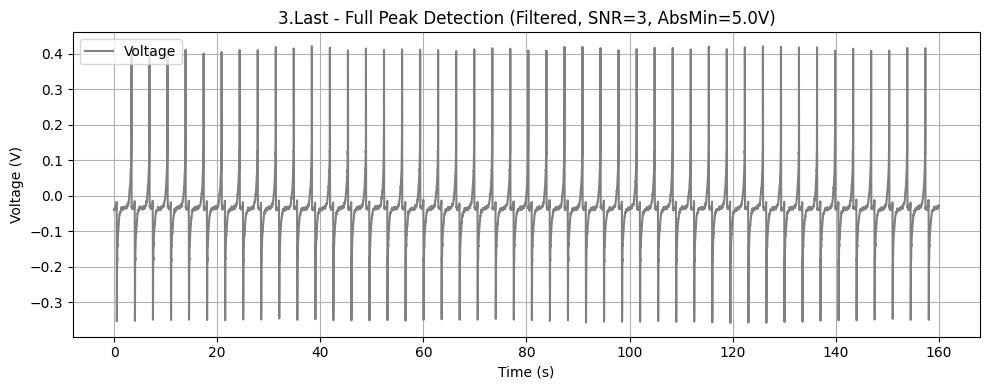

⚠️ Merge_0minimized_Fig2f | 분석 가능한 피크가 2개 미만입니다. 분석 값: 0.0 V, 0.0 Hz
📊 Merge_0minimized_Fig2f | 전체 분석 (0개 피크)
 - 평균 Peak value: 0.00 V
 - 표준편차: 0.00 V
 - 평균 주파수: 0.00 Hz


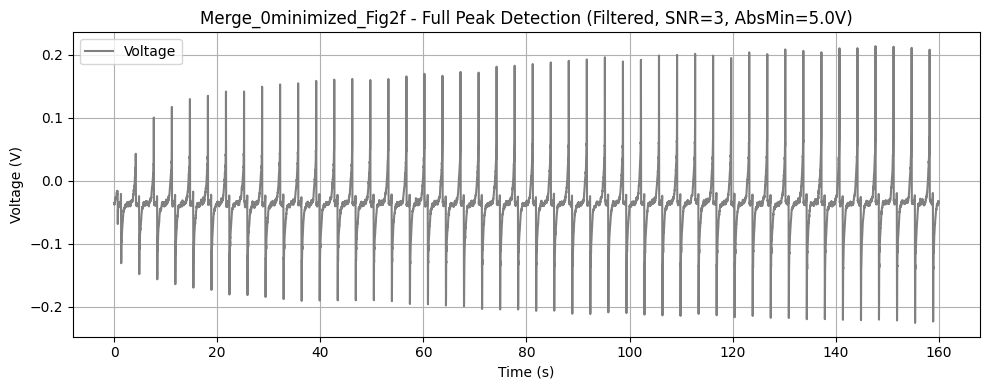


🎯 모든 파일 전체 피크 분석 결과 요약 (SNR=3, AbsMin=5.0V)
1.First.csv | Peak value: 0.00 V | 표준편차: 0.00 V | 주파수: 0.00 Hz
2.Middle.csv | Peak value: 0.00 V | 표준편차: 0.00 V | 주파수: 0.00 Hz
3.Last.csv | Peak value: 0.00 V | 표준편차: 0.00 V | 주파수: 0.00 Hz
Merge_0minimized_Fig2f.csv | Peak value: 0.00 V | 표준편차: 0.00 V | 주파수: 0.00 Hz

✨ 최종 요약 (전체 파일 평균)
📊 평균 Peak value: 0.00 V
📉 표준편차(파일별 표준편차의 평균): 0.00 V
🎵 평균 주파수: 0.00 Hz


In [4]:
# ===============================
# 🏃 분석 실행 영역
# ===============================

# 파일 목록을 가져와 이름 오름차순으로 정렬
csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

# 분석 결과를 저장할 리스트
summary_data = []

# 분석 단위 이름 설정
if peak_mode == "both":
    analysis_unit = "Vpp"
else:
    analysis_unit = "Peak value"


for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    base_name = os.path.splitext(file_name)[0]
    
    try:
        # 데이터 로드
        df = pd.read_csv(file_path, skiprows =0)
        time = df.iloc[:, 0].values
        voltage = df.iloc[:, 1].values
        
        # 🔔 NaN 값 체크 및 유효성 검사 추가 (오류 방어)
        valid_indices = ~np.isnan(time) & ~np.isnan(voltage)
        time = time[valid_indices]
        voltage = voltage[valid_indices]
        
        if len(time) < 10: # 최소 데이터 포인트 수
            print(f"❌ {file_name} 처리 중 오류 발생: 유효한 데이터 포인트가 부족합니다.")
            # ⚠️ 데이터가 없어도 그래프는 그리도록 try-except 밖으로 나가거나, 
            # 이 경우 분석은 건너뛰고 빈 summary_data만 추가하도록 처리
            mean_analysis = 0.0
            std_analysis = 0.0
            mean_freq = 0.0
            final_peaks = np.array([], dtype=int)
            
            # 데이터가 없을 경우에도 그래프를 그리도록 나머지 코드는 유지합니다.
            # 여기서는 분석 단계를 건너뛰고 바로 결과 출력 및 그래프로 이동하도록 아래 단계를 적용합니다.
            # (continue를 쓰면 그래프도 안 그려지므로, 아래 2번과 3번처럼 구조 변경이 필요)

        # 샘플링 속도 및 거리 계산
        total_time = time[-1] - time[0]
        sampling_rate = len(time) / total_time
        distance = max(1, int(sampling_rate * min_distance_sec)) # sampling rate가 매우 낮을 때 대비

        # 1. 피크 검출 (scipy.signal.find_peaks)
        prom = max(np.std(voltage) * prominence_ratio, min_prominence)

        if peak_mode == "neg":
            raw_peaks, _ = find_peaks(-voltage, prominence=prom, distance=distance)
        elif peak_mode == "pos":
            raw_peaks, _ = find_peaks(voltage, prominence=prom, distance=distance)
        elif peak_mode == "both":
            raw_peaks_pos, _ = find_peaks(voltage, prominence=prom, distance=distance)
            raw_peaks_neg, _ = find_peaks(-voltage, prominence=prom, distance=distance)
            raw_peaks = np.sort(np.concatenate([raw_peaks_pos, raw_peaks_neg]))
        else:
            raise ValueError("peak_mode는 'neg', 'pos', 'both' 중 하나여야 합니다.")

        # 2. 피크 필터링 (상대높이, SNR, 절대높이)
        max_amplitude = np.max(np.abs(voltage)) if len(voltage) > 0 else 0.0
        
        final_peaks = []
        for i in raw_peaks:
            # 국소 잡음(Local Noise) 계산
            left  = max(0, i - int(0.05 * sampling_rate))
            right = min(len(voltage), i + int(0.05 * sampling_rate))
            local_noise = max(np.std(voltage[left:right]), 1e-6)
            signal = abs(voltage[i])
            
            # 필터 조건: 상대높이 AND SNR AND 절대높이
            if (signal > max_amplitude * min_relative_height and 
                (signal / local_noise) > snr_threshold and
                signal > abs_min_height): 
                final_peaks.append(i)
        
        final_peaks = np.array(final_peaks, dtype=int)
        peak_times = time[final_peaks]

        # 3. 전체 분석 값 계산 (모든 피크 기반)
        analysis_list = []
        
        # 🔔 피크가 2개 미만일 경우 안전하게 0으로 초기화
        if len(final_peaks) < 2:
            mean_analysis = 0.0
            std_analysis = 0.0
            mean_freq = 0.0
            print(f"⚠️ {base_name} | 분석 가능한 피크가 2개 미만입니다. 분석 값: 0.0 V, 0.0 Hz")
        else:
        
            # 피크 구간 분석 (N개의 피크는 N-1개의 구간을 생성)
            for i in range(len(final_peaks) - 1):
                s = final_peaks[i]
                e = final_peaks[i + 1]
                
                if peak_mode == "both":
                    # 'both' 모드는 Vpp 계산 (구간 MAX - MIN)
                    analysis_val = np.max(voltage[s:e + 1]) - np.min(voltage[s:e + 1])
                else:
                    # 'neg'/'pos' 모드는 두 피크 절댓값의 평균
                    mag_i = np.abs(voltage[final_peaks[i]])
                    mag_i_plus_1 = np.abs(voltage[final_peaks[i+1]])
                    analysis_val = (mag_i + mag_i_plus_1) / 2
                    
                analysis_list.append(analysis_val)
                
            mean_analysis = np.mean(analysis_list) if analysis_list else 0.0
            std_analysis  = np.std(analysis_list, ddof=1) if len(analysis_list) > 1 else 0.0
            
            # 전체 평균 주파수
            periods = np.diff(peak_times)
            mean_freq = float(np.mean(1.0 / periods))

        # 전체 평균 주파수 (수정 전)
        #if len(peak_times) < 2:
        #    mean_freq = 0.0
        #else:
        #    periods = np.diff(peak_times)
        #    mean_freq = float(np.mean(1.0 / periods))

        # 4. 결과 출력 및 저장
        print(f"==================================================")
        print(f"📊 {base_name} | 전체 분석 ({len(final_peaks)}개 피크)")
        print(f" - 평균 {analysis_unit}: {mean_analysis:.2f} V")
        print(f" - 표준편차: {std_analysis:.2f} V")
        print(f" - 평균 주파수: {mean_freq:.2f} Hz")

        summary_data.append({
            "File": file_name,
            f"Mean_{analysis_unit.replace('.', '').replace(' ', '_')}": mean_analysis,
            "Std": std_analysis,
            "Freq": mean_freq
        })

        # 5. 그래프 그리기 (모든 검출 피크 표시)
        plt.figure(figsize=(10, 4))
        plt.plot(time, voltage, label='Voltage', color='gray')
        if len(final_peaks) > 0:
            plt.plot(time[final_peaks], voltage[final_peaks], 'ro', ms=4, label='Detected Peaks')
        
        plt.title(f"{base_name} - Full Peak Detection (Filtered, SNR={snr_threshold}, AbsMin={abs_min_height}V)")
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        plt.ylim(y_range)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        # 분석 중 예상치 못한 오류 발생 시 파일명과 오류만 출력 (그래프는 이미 그려졌거나 건너뛰어짐)
        print(f"❌ {file_name} 처리 중 예상치 못한 오류 발생: {e}")

# -------------------------------
# 📝 전체 요약 출력 및 CSV 저장
# -------------------------------
print("\n==================================================")
print(f"🎯 모든 파일 전체 피크 분석 결과 요약 (SNR={snr_threshold}, AbsMin={abs_min_height}V)")

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    
    # 파일별 요약 출력 (요청하신 부분)
    for index, row in summary_df.iterrows():
        print(f"{row['File']} | {analysis_unit}: {row.iloc[1]:.2f} V | "
              f"표준편차: {row['Std']:.2f} V | "
              f"주파수: {row['Freq']:.2f} Hz")
    
    # 최종 전체 평균 계산
    avg_analysis = summary_df.iloc[:, 1].mean()
    avg_std = summary_df.iloc[:, 2].mean() # 파일별 표준편차의 평균
    avg_freq = summary_df.iloc[:, 3].mean()

    print("\n==================================================")
    print("✨ 최종 요약 (전체 파일 평균)")
    print(f"📊 평균 {analysis_unit}: {avg_analysis:.2f} V")
    print(f"📉 표준편차(파일별 표준편차의 평균): {avg_std:.2f} V")
    print(f"🎵 평균 주파수: {avg_freq:.2f} Hz")
    print("==================================================")
    
    if save_summary_csv:
        # 평균값 한 줄 추가
        avg_row = {"File": "ALL_AVG"}
        avg_row[f"Mean_{analysis_unit.replace('.', '').replace(' ', '_')}"] = avg_analysis
        avg_row["Std"] = avg_std
        avg_row["Freq"] = avg_freq
        
        summary_df.loc[len(summary_df)] = avg_row

        output_path = os.path.join(folder_path, "00summary_full_peak_results_custom_filter.csv")
        summary_df.to_csv(output_path, index=False, encoding="utf-8-sig")
        print(f"✅ 요약 결과 CSV 저장 완료: {output_path}")

else:
    print("📭 처리할 CSV 파일이 없거나 오류로 인해 데이터를 계산할 수 없습니다.")